In [14]:
import sympy as sym
from sympy import Matrix
from mitroiki_functs import K_without_axial
from mitroiki_functs import P_point_load_at_distance_a, P_uniformly_distributed_load
from mitroiki_functs import round_expr

# from common.statics.mitroiki_functs import K_without_axial
# from common.statics.mitroiki_functs import P_point_load_at_distance_a, P_uniformly_distributed_load
# from common.statics.mitroiki_functs import round_expr

import openseespy.opensees as ops
import opsvis as opsv
import matplotlib.pyplot as plt

from IPython.display import Image

# Εφαρμογή 4.1 ΑΜΔ

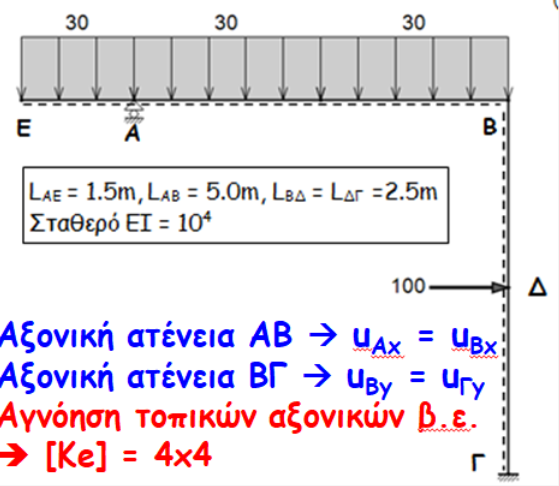

In [15]:
Image('img\ekfonisi.png', width=400)

In [16]:
E = 10_000.
I = 1.
L_ΕΑ = L0 = 1.5
L_ΑΒ = L1 = 5.0
L_ΒΔ = L_ΔΓ = 2.5
L2 = L_ΒΔ + L_ΔΓ

q_load = 30.
F_load = 100.

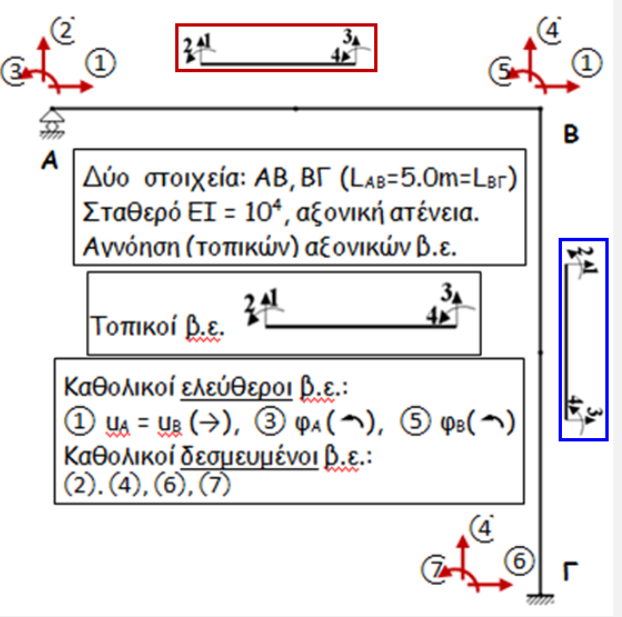

In [17]:
Image('img\dof_global.png', width=400)

## Αντιστοίχιση τοπικών - καθολικών βαθμών ελευθερίας

| Καθολ. Συστ. | (1) | (2) | (3) | (4) | (5) | (6) | (7) |
|--------------|-----|-----|-----|-----|-----|-----|-----|
| ΑΒ           | -   | 1   | 2   | 3   | 4   | -   | -   |
| ΒΓ           | 1   | -   | -   | -   | 2   | 3   | 4   |



<!-- | Header      | <span style="color:red">text</span>       | Here's this   | | | | | -->

## Μητρώα στιβαρότητας στοιχείων
Τα στοιχεία ΑΒ και ΒΓ έχουν όμοια μητρώα στιβαρότητας (ίδιες διαστάσεις, διατομές, υλικά)

In [18]:
K_ΑΒ = K_ΒΓ = K_without_axial(E=E, I=I, L=L1)
K_ΑΒ

Matrix([
[ 960.0,  2400.0,  -960.0,  2400.0],
[2400.0,  8000.0, -2400.0,  4000.0],
[-960.0, -2400.0,   960.0, -2400.0],
[2400.0,  4000.0, -2400.0,  8000.0]])

## Μητρώο στιβαρότητας φορέα
Είναι διαστάσεων 7x7 και δημιουργείται από το συνδυασμό των επιμέρους μητρώων, βάσει της αντιστοίχισης των βαθμών ελευθερίας στο καθολικό σύστημα συντεταγμένων

Δημιουργείται ένα μηδενικό μητρώο 7x7 και σταδιακά προστίθενται οι τιμές στις κατάλληλες θέσεις

In [19]:
K_temp_ΑΒ = sym.zeros(7,7)
K_temp_ΑΒ[1:5, 1:5] += K_ΑΒ
K_temp_ΑΒ

Matrix([
[0,      0,       0,       0,       0, 0, 0],
[0,  960.0,  2400.0,  -960.0,  2400.0, 0, 0],
[0, 2400.0,  8000.0, -2400.0,  4000.0, 0, 0],
[0, -960.0, -2400.0,   960.0, -2400.0, 0, 0],
[0, 2400.0,  4000.0, -2400.0,  8000.0, 0, 0],
[0,      0,       0,       0,       0, 0, 0],
[0,      0,       0,       0,       0, 0, 0]])

In [20]:
K_temp_ΒΓ = sym.zeros(7,7)
K_temp_ΒΓ[0, 0] += K_ΒΓ[0, 0]
K_temp_ΒΓ[0, 4:7] += K_ΒΓ[0, 1:4]
K_temp_ΒΓ[4:7, 0] += K_ΒΓ[1:4, 0]
K_temp_ΒΓ[4:7, 4:7] += K_ΒΓ[1:, 1:]
K_temp_ΒΓ

Matrix([
[ 960.0, 0, 0, 0,  2400.0,  -960.0,  2400.0],
[     0, 0, 0, 0,       0,       0,       0],
[     0, 0, 0, 0,       0,       0,       0],
[     0, 0, 0, 0,       0,       0,       0],
[2400.0, 0, 0, 0,  8000.0, -2400.0,  4000.0],
[-960.0, 0, 0, 0, -2400.0,   960.0, -2400.0],
[2400.0, 0, 0, 0,  4000.0, -2400.0,  8000.0]])

Οπότε το συνολικό μητρώο του φορέα είναι το $Κ$

In [21]:
K = K_temp_ΑΒ + K_temp_ΒΓ
K

Matrix([
[ 960.0,      0,       0,       0,  2400.0,  -960.0,  2400.0],
[     0,  960.0,  2400.0,  -960.0,  2400.0,       0,       0],
[     0, 2400.0,  8000.0, -2400.0,  4000.0,       0,       0],
[     0, -960.0, -2400.0,   960.0, -2400.0,       0,       0],
[2400.0, 2400.0,  4000.0, -2400.0, 16000.0, -2400.0,  4000.0],
[-960.0,      0,       0,       0, -2400.0,   960.0, -2400.0],
[2400.0,      0,       0,       0,  4000.0, -2400.0,  8000.0]])

## Μητρώο εξωτερικής φόρτισης

### Στοιχείο ΑΒ
Το στοιχείο ΑΒ παραλαμβάνει τα φορτία του προβόλου καθώς και τη φόρτιση από το ομοιόμορφα κατανεμημένο φορτίο q

In [22]:
P_AB_uniform = P_uniformly_distributed_load(q=q_load, L=L_ΑΒ)
P_AB_uniform

Matrix([
[-75.0],
[-62.5],
[-75.0],
[ 62.5]])

In [23]:
P_AB_provolos = Matrix([-q_load*L_ΕΑ, q_load*L_ΕΑ**2/2, 0, 0])
P_AB_provolos

Matrix([
[-45.0],
[33.75],
[    0],
[    0]])

Προσθέτοντας τα 2 παραπάνω μητρώα προκύπτει το $P_{AB}$

In [24]:
P_AB = P_AB_uniform + P_AB_provolos
P_AB

Matrix([
[-120.0],
[-28.75],
[ -75.0],
[  62.5]])

### Στοιχείο ΒΓ
Το ΒΓ φέρει μόνο το ομοιόμορφο φορτίο $F=100\text{kN}$

**Προσοχή**: Σύμφωνα με την ίνα αναφοράς του στοιχείου ΒΓ, το φορτίο πρέπει να μπει με αρνητικό πρόσημο για τον υπολογισμό του $P_{ΒΓ}$

In [25]:
P_ΒΓ = P_point_load_at_distance_a(P=-F_load, a=L_ΒΔ, L=L2)
P_ΒΓ

Matrix([
[ 50.0],
[ 62.5],
[ 50.0],
[-62.5]])

### Συνολικό μητρώο εξωτερικής φόρτισης

Για να προκύψει το συνολικό μητρώο $P$, συνδυάζονται τα επιμέρους μητρώα των δύο στοιχείων, λαμβάνοντας υπόψη τη συσχέτιση των τοπικών με τους καθολικούς βαθμούς ελευθερίας

| Καθολ. Συστ. | (1) | (2) | (3) | (4) | (5) | (6) | (7) |
|--------------|-----|-----|-----|-----|-----|-----|-----|
| ΑΒ           | -   | 1   | 2   | 3   | 4   | -   | -   |
| ΒΓ           | 1   | -   | -   | -   | 2   | 3   | 4   |

Δημιουργείται ένα μητρώο 7x1 και στη συνέχεια προστίθενται οι τιμές στις κατάλληλες θέσεις

<!-- <img src="img\ina_anaforas.png" width="400"> -->

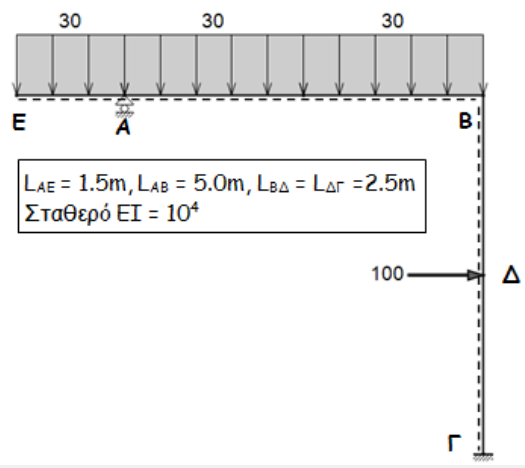

In [26]:
Image('img\ina_anaforas.png', width=400)

In [27]:
P_temp_AB = sym.zeros(7,1)
P_temp_AB[1:5, 0] += P_AB
P_temp_AB

Matrix([
[     0],
[-120.0],
[-28.75],
[ -75.0],
[  62.5],
[     0],
[     0]])

In [28]:
P_temp_ΒΓ = sym.zeros(7,1)
P_temp_ΒΓ[0,0] += P_ΒΓ[0]
P_temp_ΒΓ[4:,0] += P_ΒΓ[1:,0]
P_temp_ΒΓ

Matrix([
[ 50.0],
[    0],
[    0],
[    0],
[ 62.5],
[ 50.0],
[-62.5]])

In [29]:
P = P_temp_AB + P_temp_ΒΓ
P

Matrix([
[  50.0],
[-120.0],
[-28.75],
[ -75.0],
[ 125.0],
[  50.0],
[ -62.5]])

## Δεσμευμένοι και ελεύθεροι βαθμοί ελευθερίας

<!-- <img src="img\restrained_vs_free.png" width="400"> -->

Οι δεσμευμένοι βαθμοί ελευθερίας στο καθολικό σύστημα είναι οι <span style="color:red">(2)</span>,  <span style="color:red">(4)</span>, <span style="color:red">(6)</span>, <span style="color:red">(7)</span> λόγω της κύλισης στον κόμβο Α και της πάκτωσης στον κόμβο Γ.

Αντίθετα, ελεύθεροι είναι οι βαθμοί ελευθερίας <span style="color:blue">(1)</span>, <span style="color:blue">(3)</span> και <span style="color:blue">(5)</span>

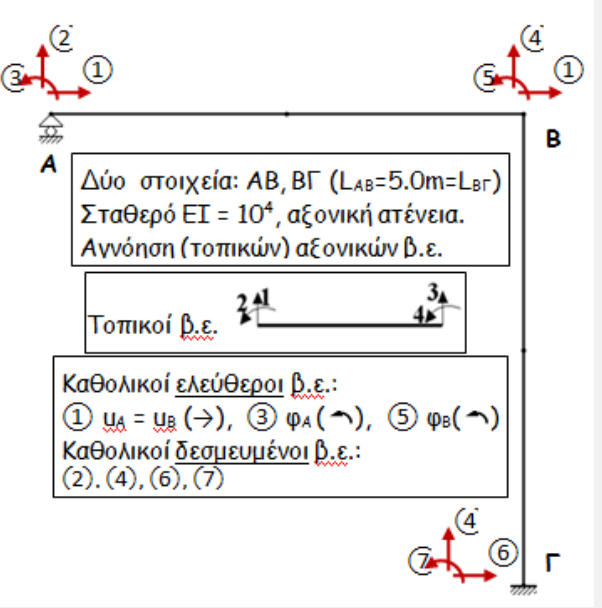

In [30]:
Image(r'img\restrained_vs_free.png', width=400)

## Διαχωρισμός μητρώων

| Καθολ. Συστ. | <span style="color:blue">(1)</span> | <span style="color:red">(2)</span> | <span style="color:blue">(3)</span> | <span style="color:red">(4)</span> | <span style="color:blue">(5)</span> | <span style="color:red">(6)</span> | <span style="color:red">(7)</span> |
|--------------|-----|-----|-----|-----|-----|-----|-----|
| ΑΒ           | -   | 1   | 2   | 3   | 4   | -   | -   |
| ΒΓ           | 1   | -   | -   | -   | 2   | 3   | 4   |

<!-- <img src="img\Kuu_vs_Kru.png" width="600"> -->

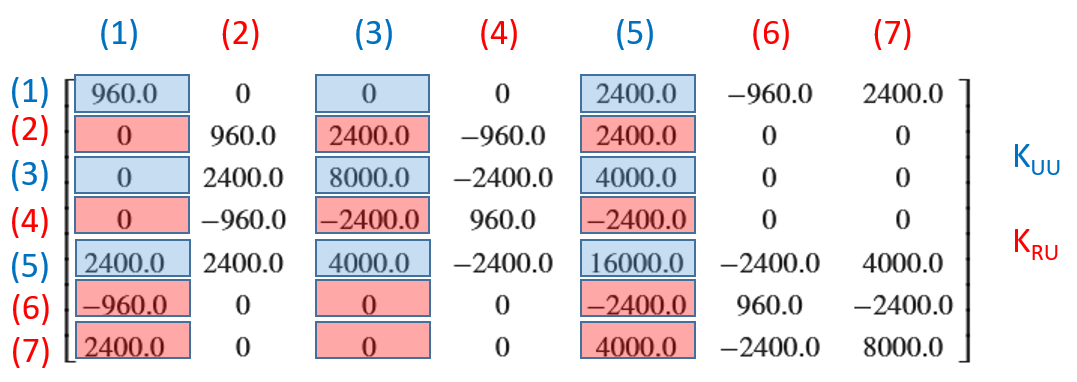

In [31]:
Image(r'img\Kuu_vs_Kru.png', width=600)

Ομοίως και για τα μητρώα εξωτερικής φόρτισης, παραμορφώσεων και αντιδράσεων

<!-- <img src="img\PUR.png" width="700"> -->

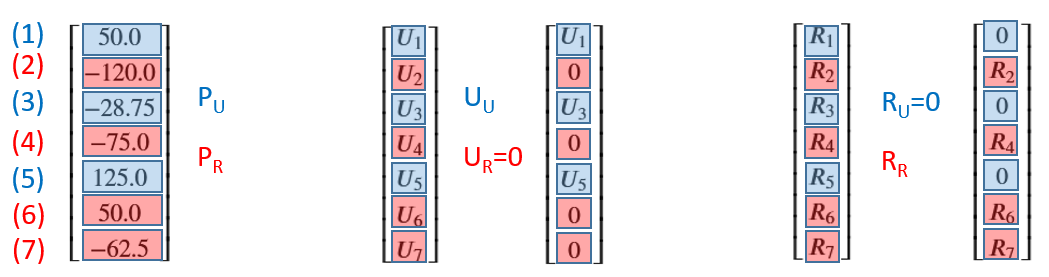

In [32]:
Image(r'img\PUR.png', width=700)

### Υπομητρώα στιβαρότητας

In [33]:
K_UU = K[[0, 2, 4], [0, 2, 4]]
K_UU

Matrix([
[ 960.0,      0,  2400.0],
[     0, 8000.0,  4000.0],
[2400.0, 4000.0, 16000.0]])

In [34]:
K_RU = K[[1, 3, 5, 6], [0, 2, 4]]
K_RU

Matrix([
[     0,  2400.0,  2400.0],
[     0, -2400.0, -2400.0],
[-960.0,       0, -2400.0],
[2400.0,       0,  4000.0]])

### Υπομητρώα εξωτερικής φόρτισης

In [35]:
P_U = P[[0, 2, 4], 0]
P_U

Matrix([
[  50.0],
[-28.75],
[ 125.0]])

In [36]:
P_R = P[[1, 3, 5, 6], 0]
P_R

Matrix([
[-120.0],
[ -75.0],
[  50.0],
[ -62.5]])

## Υπολογισμός παραμορφώσεων

Είναι $K_{UU}\cdot U_U = P_U + R_U$, με $R_U=0$

οπότε $K_{UU}\cdot U_U = P_U$

και τελικά $U_U = K_{UU}^{-1}\cdot P_U$

In [37]:
U_U = K_UU.inv() * P_U
round_expr(U_U, 5)

Matrix([
[ 0.04759],
[-0.00449],
[  0.0018]])

## Υπολογισμός αντιδράσεων στήριξης

Είναι $K_{RU}\cdot U_U = P_R + R_R$

οπότε $R_R = K_{RU}\cdot U_U - P_R$

In [38]:
R_R = K_RU*U_U - P_R
round_expr(R_R, 3)

Matrix([
[113.531],
[ 81.469],
[ -100.0],
[183.906]])

## Επίλυση/έλεγχος με το OpenSees

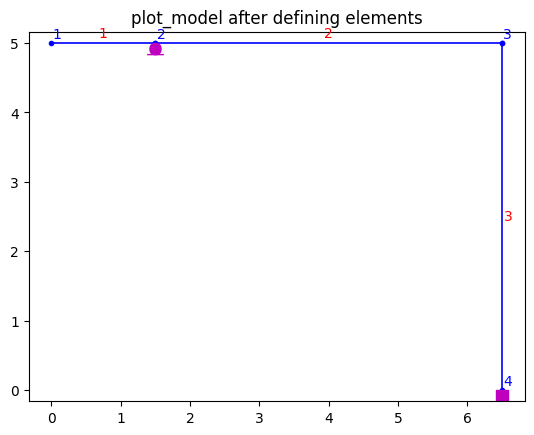

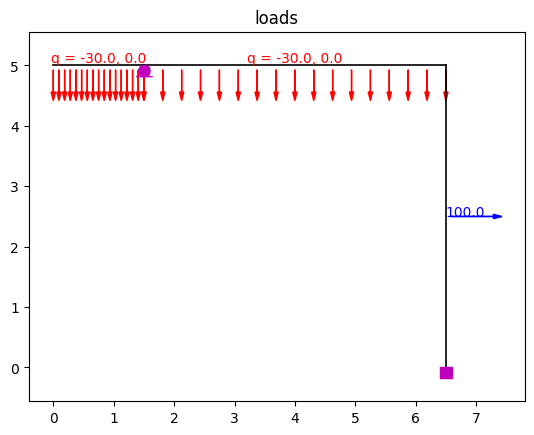

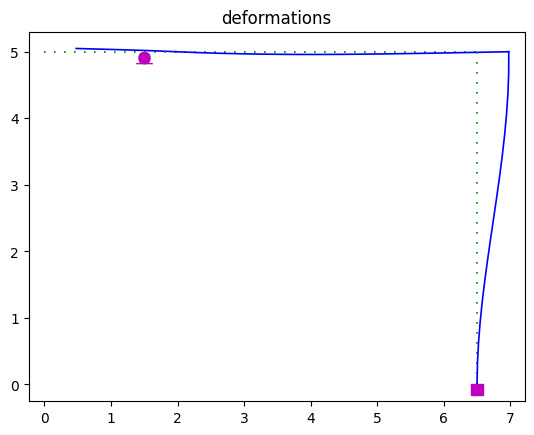

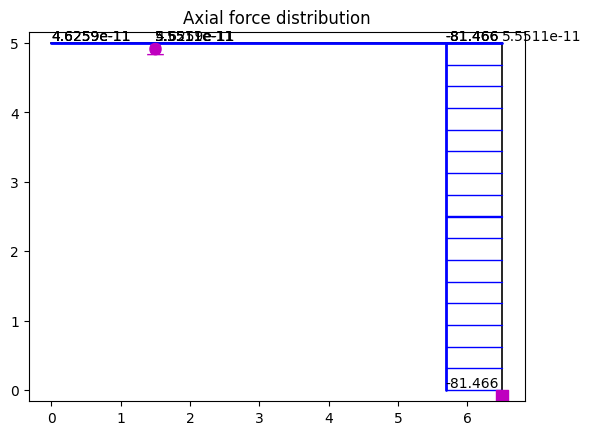

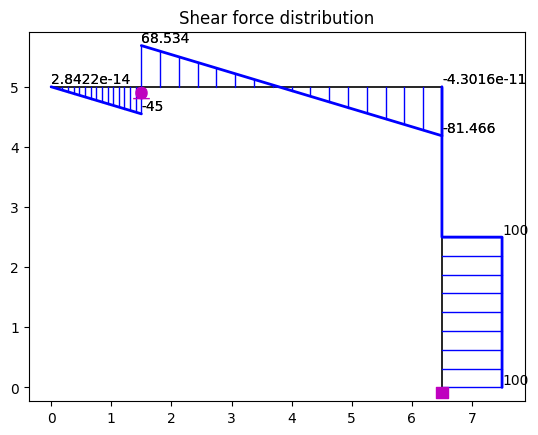

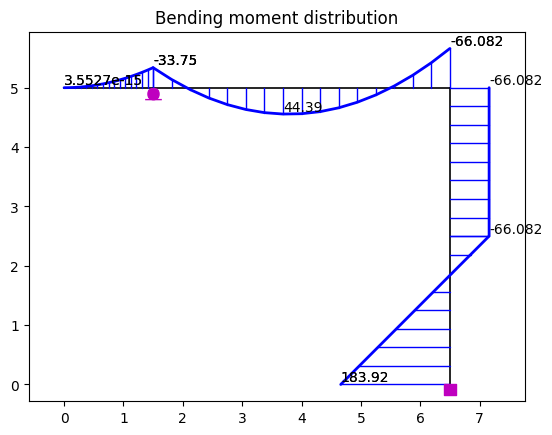

In [39]:
ops.wipe()
ops.model('basic', '-ndm', 2, '-ndf', 3)

A = 1000.
I = 1.
E = 10_000.

ops.node(1, 0., L2)
ops.node(2, L0, L2)
ops.node(3, L0+L1, L2)
ops.node(4, L0+L1, 0)

ops.fix(2, 0, 1, 0)
ops.fix(4, 1, 1, 1)

# opsv.plot_model()
# plt.title('plot_model before defining elements')

ops.geomTransf('Linear', 1)

# elements
ops.element('elasticBeamColumn', 1, 1, 2, A, E, I, 1)
ops.element('elasticBeamColumn', 2, 2, 3, A, E, I, 1)
ops.element('elasticBeamColumn', 3, 3, 4, A, E, I, 1)


# loads
ops.timeSeries('Constant', 1)
ops.pattern('Plain', 1, 1)

ops.eleLoad('-ele', 1, '-type', '-beamUniform', -q_load)
ops.eleLoad('-ele', 2, '-type', '-beamUniform', -q_load)
ops.eleLoad('-ele', 3, '-type', '-beamPoint', F_load, 0.5)


# analysis
ops.constraints('Transformation')
ops.numberer('RCM')
ops.system('BandGeneral')
ops.test('NormDispIncr', 1.0e-6, 6, 2)
ops.algorithm('Linear')
ops.integrator('LoadControl', 1)
ops.analysis('Static')
ops.analyze(1)

# results
# ops.printModel()
opsv.plot_model()
plt.title('plot_model after defining elements')

opsv.plot_loads_2d()
plt.title('loads')

sfac = 10.
opsv.plot_defo(sfac)
plt.title('deformations')

sfacN, sfacV, sfacM = 1.e-2, 1.e-2, 1.e-2
opsv.section_force_diagram_2d('N', sfacN)
plt.title('Axial force distribution')

opsv.section_force_diagram_2d('T', sfacV)
plt.title('Shear force distribution')

opsv.section_force_diagram_2d('M', sfacM)
plt.title('Bending moment distribution')


plt.show()

In [40]:
# U1, U2, U3, U4, U5, U6, U7 = sym.symbols('U1 U2 U3 U4 U5 U6 U7')
# P1, P2, P3, P4, P5, P6, P7 = sym.symbols('P1 P2 P3 P4 P5 P6 P7')
# R1, R2, R3, R4, R5, R6, R7 = sym.symbols('R1 R2 R3 R4 R5 R6 R7')

In [41]:
# U = Matrix([[U1], [U2], [U3], [U4], [U5], [U6], [U7]])
# U

In [42]:
# U.subs(U2, 0).subs(U4, 0).subs(U6, 0).subs(U7, 0)

In [43]:
# P = Matrix([[P1], [P2], [P3], [P4], [P5], [P6], [P7]])
# P

In [44]:
# R = Matrix([[R1], [R2], [R3], [R4], [R5], [R6], [R7]])
# R

In [45]:
# R.subs(R1, 0).subs(R3, 0).subs(R5, 0)